<a href="https://colab.research.google.com/github/kamileo96/GNN-Tracking/blob/main/GNN_muonE_3D_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial: GNNs for Particle Tracking

HEP.TrkX group

Steve Farrell, Daniel Murname

*Feb 2020*

Adapted for MuonE tracking by Marcin Wolter

*July 2020*

In [ ]:
!pip uninstall torchvision torchtext torchaudio --yes
!pip install torch==1.11.0+cu113  -f https://download.pytorch.org/whl/torch_stable.html

Found existing installation: torchvision 0.14.1+cu116
Uninstalling torchvision-0.14.1+cu116:
  Successfully uninstalled torchvision-0.14.1+cu116
Found existing installation: torchtext 0.14.1
Uninstalling torchtext-0.14.1:
  Successfully uninstalled torchtext-0.14.1
Found existing installation: torchaudio 0.13.1+cu116
Uninstalling torchaudio-0.13.1+cu116:
  Successfully uninstalled torchaudio-0.13.1+cu116
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 GB 1.1 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.13.1+cu116
    Uninstalling torch-1.13.1+cu116:
      Successfully uninstalled torch-1.13.1+cu116
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fa

In [ ]:
# System imports
import os
import sys
from pprint import pprint as pp
from time import time as tt

# External imports
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import pandas as pd
import seaborn as sns
import torch

In [ ]:
print("PyTorch version:",print(torch.__version__),", CUDA version:", torch.version.cuda)

1.11.0+cu113
PyTorch version: None , CUDA version: 11.3


In [ ]:
#!pip install torch-scatter==latest+cu101 torch-sparse==latest+cu101 -f https://s3.eu-central-1.amazonaws.com/pytorch-geometric.com/whl/torch-1.5.0.html
"""
!pip install torch-geometric
!pip install torch-sparse
!pip install torch-scatter"""
# MW corrected

!pip install torch-geometric \
  torch-sparse==0.6.13 \
  torch-scatter==2.0.9 \
  -f https://pytorch-geometric.com/whl/torch-1.11.0+cu113.html


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.11.0+cu113.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.0/565.0 KB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 KB 23.4 MB/s eta 0:00:00
  Created wheel for torch-geometric: filename=torch_geometric-2.2.0-py3-none-any.whl size=773302 sha256=3495a2758abe49a621dd38b6e998cb0d6bcbbcfdd9418aede3a28cebcd28d1a9
  Stored in directory: /root/.cache/pip/wheels/59/a3/20/198928106d3169865ae73afcbd3d3d1796cf6b429b55c65378
Successfully built torch-geometric
  Attempting uninstall: psutil
    Found existing installation: psutil 5.4.8
    Uninstalling psutil-5.4.8:
      Successfully uninstalled psutil-5.4.8


In [ ]:
from torch_geometric.data import Data
from torch_geometric.data import DataLoader
import torch.nn as nn
from torch_scatter import scatter_add
import torch.nn.functional as F

import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from IPython.display import clear_output
from IPython.display import HTML, display

%matplotlib inline

# Get rid of RuntimeWarnings, gross
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

## A Simple GNN

### Message Passing GNN

We can write out the full GNN as a class `MPNN_Network`. One can see its behaviour as:
1. Encode (x,y) features as hidden features with an N-layer MLP called `node_encoder`
2. Concatenate these along each edge, and feed the concatenated features into another MLP called `edge_network`
3. Sum the output of `edge_classifier` at each node (that is, each node receives the sum of the "messages" of all connecting edges). This sum is fed into `node_network`
4. Add the hidden features to the previous iteration (this helps to preserve information between messages)
5. Repeat (2) --> (4) n_graph_iters times
6. After the message passing loop, pass the features of each edge through an output classifier network called `edge_classifier`

In [ ]:
def make_mlp(input_size, sizes,
             hidden_activation='ReLU',
             output_activation='ReLU',
             layer_norm=False):
    """Construct an MLP with specified fully-connected layers."""
    hidden_activation = getattr(nn, hidden_activation)
    if output_activation is not None:
        output_activation = getattr(nn, output_activation)
    layers = []
    n_layers = len(sizes)
    sizes = [input_size] + sizes
    # Hidden layers
    for i in range(n_layers-1):
        layers.append(nn.Linear(sizes[i], sizes[i+1]))
        if layer_norm:
            layers.append(nn.LayerNorm(sizes[i+1]))
        layers.append(hidden_activation())
    # Final layer
    layers.append(nn.Linear(sizes[-2], sizes[-1]))
    if output_activation is not None:
        if layer_norm:
            layers.append(nn.LayerNorm(sizes[-1]))
        layers.append(output_activation())
    return nn.Sequential(*layers)

class MPNN_Network(nn.Module):
    """
    A message-passing graph network which takes a graph with:
    - bi-directional edges
    - node features, no edge features

    and applies the following modules:
    - a graph encoder (no message passing)
    - recurrent edge and node networks
    - an edge classifier
    """

    def __init__(self, input_dim, hidden_node_dim, hidden_edge_dim, in_layers, node_layers, edge_layers,
                 n_graph_iters=1, layer_norm=True):
        super(MPNN_Network, self).__init__()
        self.n_graph_iters = n_graph_iters

        # The node encoder transforms input node features to the hidden space
        self.node_encoder = make_mlp(input_dim, [hidden_node_dim]*in_layers)

        # The edge network computes new edge features from connected nodes
        self.edge_network = make_mlp(2*hidden_node_dim,
                                     [hidden_edge_dim]*edge_layers,
                                     layer_norm=layer_norm)

        # The node network computes new node features
        self.node_network = make_mlp(hidden_node_dim + hidden_edge_dim,
                                     [hidden_node_dim]*node_layers,
                                     layer_norm=layer_norm)

        # The edge classifier computes final edge scores
        self.edge_classifier = make_mlp(2*hidden_node_dim,
                                        [hidden_edge_dim, 1],
                                        output_activation=None)

    def forward(self, data):
        # Make every edge bi-directional
        send_idx = torch.cat([data.edge_index[0], data.edge_index[1]], dim=0)
        recv_idx = torch.cat([data.edge_index[1], data.edge_index[0]], dim=0)

        # Encode the graph features into the hidden space
        x = self.node_encoder(data.x)

        # Loop over graph iterations
        for i in range(self.n_graph_iters):

            # Previous hidden state
            x0 = x

            # Compute new edge features
            edge_inputs = torch.cat([x[send_idx], x[recv_idx]], dim=1)
            e = self.edge_network(edge_inputs)

            # Sum edge features coming into each node
            aggr_messages = scatter_add(e, recv_idx, dim=0, dim_size=x.shape[0])

            # Compute new node features
            node_inputs = torch.cat([x, aggr_messages], dim=1)
            x = self.node_network(node_inputs)

            # Residual connection
            x = x + x0

        # Compute final edge scores; use original edge directions only
        start_idx, end_idx = data.edge_index
        clf_inputs = torch.cat([x[start_idx], x[end_idx]], dim=1)
        return self.edge_classifier(clf_inputs).squeeze(-1)

Build a version of the model and print it out.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
m_configs = {"input_dim": 3, "hidden_node_dim": 64, "hidden_edge_dim": 64, "in_layers": 2, "node_layers": 4, "edge_layers": 4, "n_graph_iters": 1, "layer_norm": True}
model = MPNN_Network(**m_configs).to(device)
model

MPNN_Network(
  (node_encoder): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
  )
  (edge_network): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (8): ReLU()
    (9): Linear(in_features=64, out_features=64, bias=True)
    (10): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (11): ReLU()
  )
  (node_network): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_feature

### Training

In [ ]:
def train(model, train_loader, optimizer):
    correct = 0
    total = 0
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        data = batch.to(device)
        pred = model(data)
        loss = F.binary_cross_entropy_with_logits(pred.float(), data.y.float(), pos_weight=torch.tensor(weight))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += ((pred > 0.5) == (data.y > 0.5)).sum().item()
        total += len(pred)
    acc = correct/total
    return acc, total_loss

def evaluate(model, test_loader):
    correct = 0
    total = 0
    total_loss = 0
    for batch in test_loader:
        data = batch.to(device)
        pred = model(data)
        loss = F.binary_cross_entropy_with_logits(pred.float(), data.y.float(), pos_weight=torch.tensor(weight))
        total_loss += loss.item()
        correct += ((pred > 0.5) == (data.y > 0.5)).sum().item()
        total += len(pred)
    acc = correct/total
    return acc, total_loss

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import numpy as np, pandas as pd
from torch_geometric.data import Data
from torch_geometric.data import DataLoader

feature_scale_d = 1/10
feature_scale_z = 1/1000
def phi_d_z(row):
  return 0
def gen_points(sub_event, hitType_phi):
  phis = hitType_phi[sub_event['hitType'].to_numpy(dtype=int)]
  ds = sub_event['hitPos'].to_numpy() * feature_scale_d
  zs = sub_event['layerZ'].to_numpy() * feature_scale_z
  return np.array([phis, ds, zs])

def gen_edges(bf, af):
  #bf (before) - num of points with 1 hit  per layer
  #af (after)  - num of points with 2 hits per layer
  #total - total number of points
  total = bf + af*2
  #this connects the graph like this: ---<===
  #and then adds fake edges between two tracks 'X'
  #         3 - 4 - 5
  # -0-1-2<   X   X
  #         6 - 7 - 8
  true_edges = [[i, i+1] for i in range(total-1)]
  true_edges.append([bf-1, bf + af])
  true_edges.remove([bf + af - 1, bf + af])

  fake_edges = []
  for i in range(af-1):
    a = bf + i
    b = bf + af + i
    fake_edges.append([a, b + 1])
    fake_edges.append([b, a + 1])
  #[[from],[to]]
  edges = np.array(true_edges + fake_edges).T
  y = np.append(np.ones(len(true_edges)), np.zeros(len(fake_edges)))
  return edges, y

def ShuffleIndexSwap(Edges, nIdx):
  #changes edges according to the shuffled index
  my_dict = {}
  for i in range(len(nIdx)):
    my_dict[i] = nIdx[i]
  
  return np.vectorize(my_dict.get)(Edges)

def gen3D_event_data(event, hitType_phi):
  dfs = []
  for num, df_i in event.groupby(event['trackID']):
    if num not in [0, 1, 2]:
      #raise ValueError(f'Hit type {num} is incorrect')
      pass
    else:
      dfs.append(df_i.sort_values('layerIndex'))
  df0, df1, df2 = dfs
  p0s = gen_points(df0, hitType_phi)
  p1s = gen_points(df1, hitType_phi)
  p2s = gen_points(df2, hitType_phi)
  x = np.concatenate((p0s, p1s, p2s), axis=1).T
  edges, y = gen_edges(p0s.shape[1], p1s.shape[1])
  #as of now the data is not shuffled at all, so:
  #shuffling points:
  nIdx = np.arange(len(x))
  np.random.shuffle(nIdx)
  edges = ShuffleIndexSwap(edges, nIdx)
  x[nIdx] = x.copy()
  #shuffling edges:
  
  neidx = np.arange(len(y))
  np.random.shuffle(neidx)
  edges[0] = edges[0][neidx]
  edges[1] = edges[1][neidx]
  y = y[neidx]

  #combining into Data:
  event_data = Data(x = torch.from_numpy(x).float(), edge_index = torch.from_numpy(edges), y = torch.from_numpy(y))
  return event_data

def LoadHitFile(event_file, hitType_phi):
  data = pd.read_csv(event_file)
  data.rename(columns=lambda x: x.strip(), inplace=True)
  event_data_list = []
  for num, event in data.groupby(data['nEvent']):
    try:
      event_data_list.append(gen3D_event_data(event, hitType_phi))
    except Exception as e:
      #print(f'Event number {num} unusable.')
      #print(e)
      #as of now an error is raised when a particle doesn't reach the 15th layer
      pass
  return event_data_list


In [ ]:
event_file= "/content/drive/My Drive/MuonE_tracking/hitFile_small.csv"
data = pd.read_csv(event_file)
data.rename(columns=lambda x: x.strip(), inplace=True)

#angle between detection axis and x axis for hit type i
hitType_phi = np.array([0, np.pi/2, np.pi/4, -np.pi/4])

In [ ]:
dataset = LoadHitFile(event_file, hitType_phi)

In [ ]:
from sklearn.model_selection import train_test_split
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=True)

/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:12: UserWarning:

'data.DataLoader' is deprecated, use 'loader.DataLoader' instead



In [ ]:
train_dataset[0]

Data(x=[26, 3], edge_index=[2, 43], y=[43])

In [ ]:
event = data[data['nEvent'] == 2]
print(gen3D_event_data(event, hitType_phi))

Data(x=[26, 3], edge_index=[2, 43], y=[43])


In [ ]:
print(train_dataset[0].x,
train_dataset[0].edge_index,
train_dataset[0].y)

tensor([[ 0.0000e+00,  2.3124e+00,  1.9600e+00],
        [ 0.0000e+00,  1.8969e-02,  1.2660e+00],
        [ 1.5708e+00, -3.9622e-01,  8.3200e-01],
        [ 1.5708e+00, -8.1466e-01,  1.1460e+00],
        [ 0.0000e+00,  1.1568e+00,  1.2660e+00],
        [ 1.5708e+00, -1.2650e+00,  1.4796e+00],
        [ 1.5708e+00, -6.2962e-03,  8.3200e-01],
        [-7.8540e-01,  3.1549e-02,  1.4674e+00],
        [ 1.5708e+00, -1.3312e-02,  1.1460e+00],
        [ 1.5708e+00, -1.9539e+00,  1.9730e+00],
        [ 1.5708e+00, -3.5069e-04,  4.7700e-01],
        [ 0.0000e+00,  1.5726e-02,  1.1410e+00],
        [ 0.0000e+00,  4.8924e-01,  8.4370e-01],
        [ 0.0000e+00, -2.6839e-05,  1.5100e-01],
        [ 1.5708e+00, -1.3497e-04,  1.3100e-01],
        [ 0.0000e+00,  1.8370e-09, -2.1000e-02],
        [ 7.8540e-01,  1.2575e-01,  1.2527e+00],
        [ 1.5708e+00, -2.3920e-06, -1.6000e-02],
        [ 7.8540e-01,  2.1061e-03,  1.2527e+00],
        [-7.8540e-01,  1.9408e+00,  1.4674e+00],
        [ 0.0000e+00

In [ ]:
weight = ((len(train_dataset[0].y) - train_dataset[0].y.sum().item()) / train_dataset[0].y.sum().item())
print("True / Fake = ", 1/weight)
print("Fake / True = ", weight)

True / Fake =  1.3888888888888888
Fake / True =  0.72


In [ ]:
t_loss_v = []
t_acc_v = []
v_loss_v = []
v_acc_v = []
ep = 0

#weight = 2

m_configs = {"input_dim": 3, "hidden_node_dim": 64, "hidden_edge_dim": 32, "in_layers": 4, "node_layers": 4, "edge_layers": 4, "n_graph_iters": 20, "layer_norm": True}
model = MPNN_Network(**m_configs).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4, amsgrad=True)

t_loss_v = []
t_acc_v = []
v_loss_v = []
v_acc_v = []
ep = 0
for epoch in range(50):
    ep += 1  
    model.train()
    acc, total_loss = train(model, train_loader, optimizer)
    t_loss_v.append(total_loss)
    t_acc_v.append(acc)

    model.eval()
    acc, total_loss = evaluate(model, test_loader)
    v_loss_v.append(total_loss)
    v_acc_v.append(acc)

    print('Epoch: {}, Accuracy: {:.4f}'.format(ep, acc))


Epoch: 1, Accuracy: 0.5820
Epoch: 2, Accuracy: 0.4186
Epoch: 3, Accuracy: 0.4419
Epoch: 4, Accuracy: 0.4419
Epoch: 5, Accuracy: 0.5349
Epoch: 6, Accuracy: 0.5814
Epoch: 7, Accuracy: 0.5814
Epoch: 8, Accuracy: 0.5814
Epoch: 9, Accuracy: 0.5814
Epoch: 10, Accuracy: 0.5814
Epoch: 11, Accuracy: 0.5814
Epoch: 12, Accuracy: 0.5814
Epoch: 13, Accuracy: 0.5814
Epoch: 14, Accuracy: 0.5814
Epoch: 15, Accuracy: 0.5814
Epoch: 16, Accuracy: 0.5814
Epoch: 17, Accuracy: 0.5814
Epoch: 18, Accuracy: 0.5814
Epoch: 19, Accuracy: 0.5814
Epoch: 20, Accuracy: 0.5814
Epoch: 21, Accuracy: 0.5814
Epoch: 22, Accuracy: 0.5814
Epoch: 23, Accuracy: 0.5814
Epoch: 24, Accuracy: 0.5814
Epoch: 25, Accuracy: 0.5814
Epoch: 26, Accuracy: 0.5814
Epoch: 27, Accuracy: 0.5814
Epoch: 28, Accuracy: 0.5814
Epoch: 29, Accuracy: 0.5814
Epoch: 30, Accuracy: 0.5814
Epoch: 31, Accuracy: 0.5814
Epoch: 32, Accuracy: 0.5814
Epoch: 33, Accuracy: 0.5814
Epoch: 34, Accuracy: 0.5814
Epoch: 35, Accuracy: 0.5814
Epoch: 36, Accuracy: 0.5814
E

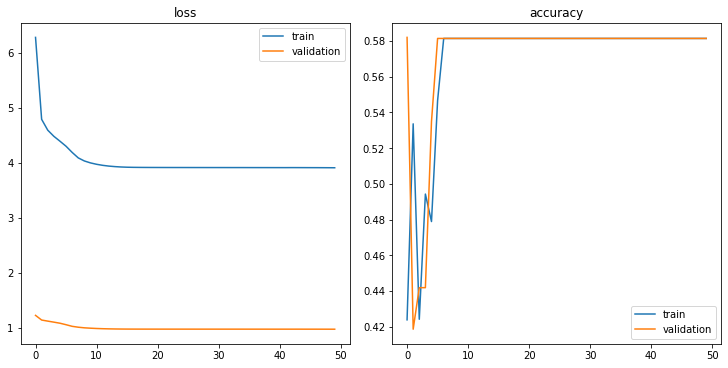

In [ ]:
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 5))
axs[0].set_title("loss")
axs[0].set_yscale("linear")
axs[0].plot(np.arange(len(t_loss_v)), t_loss_v, label='train')
axs[0].plot(np.arange(len(v_loss_v)), v_loss_v, label='validation')
axs[0].legend()

axs[1].set_title("accuracy")
axs[1].plot(np.arange(len(t_acc_v)), t_acc_v, label='train')
axs[1].plot(np.arange(len(v_acc_v)), v_acc_v, label='validation')
axs[1].legend()
axs[1].set_yscale("linear")

In [ ]:
import plotly.express as px
def xy_from_phi(phi, d, r):
  x = np.cos(phi)*d + np.sin(phi)*r
  y = np.sin(phi)*d - np.cos(phi)*r
  return x, y
def plot_strips_3D(data):
  r = 1
  phis, ds, zs = data.x[:,0].numpy(), data.x[:,1].numpy(), data.x[:,2].numpy()
  df = pd.DataFrame([], columns=['x', 'y', 'z', 'label'])
  for j, phi, d, z in zip(range(len(phis)), phis, ds, zs):
    p1 = [*xy_from_phi(phi, d, +r), z, j]
    p2 = [*xy_from_phi(phi, d, -r), z, j]
    print(phi)
    df2 = pd.DataFrame([p1, p2], columns=['x', 'y', 'z', 'label'])
    df = df.append(df2, ignore_index=True)
  fig = px.line_3d(df, x='x', y='y', z='z', line_group='label')
  fig.show()

In [ ]:
plot_strips_3D(train_dataset[5])

1.5707964
0.0
1.5707964
0.0
0.0
1.5707964
0.7853982
0.0
1.5707964
0.0
0.0
0.0
0.0
1.5707964
0.0
0.0
1.5707964
1.5707964
0.0
1.5707964
1.5707964
0.7853982
-0.7853982
-0.7853982
1.5707964
1.5707964
